In [1]:
from langchain_ollama import OllamaLLM
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END
from db_create import CargaDeArchivos
import re

In [2]:
from typing import List

a= CargaDeArchivos()
a.run_carga()
db_conn= a.conn

class State(TypedDict):
    """
    Represents the state of the workflow, including the question, schema, database connection,
    relevance, SQL query, query result, and other metadata.
    """
    original_question: str
    questions: List[str] = []
    db_conn: None
    relevance: str
    sql_querys: List[str] = []
    query_results: List[str] = []
    sql_error: bool
    final_answer: str
    attempts: int
    chat_history: List[str] = []

In [3]:
def check_relevance(state: State):
    """
    Determines whether the user's question is relevant to the database schema.

    Args:
        state (State): The current state of the workflow.

    Returns:
        State: Updated state with relevance information.
    """
    question = state["original_question"]
    print(f"Checking relevance of the question: {question}")

    # Retrieve chat history
    chat_history_entries = state.get("chat_history", [])
    
    chat_history= relevant_entries(chat_history_entries)  # Get the last 3 relevant entries
    print(f"Chat history for relevance check:\n{chat_history}")
    # System prompt including instructions on chat history usage
    system = f"""
    You are an assistant that determines whether a given question is related to querying the following database schema.
    A question is considered **relevant** only if it is structured in a way that could be used to extract data from the database.
    
    General conversations, greetings, and small talk are **not relevant**, even if they contain words related to business or databases.

    ### **How to Use Chat History:**
    - If the user's question is a **follow-up to a previous relevant question**, consider it relevant if it maintains the context.
    - If the conversation was **not relevant before**, and the new question is vague or generic, it remains **not relevant**.
    - Do **not** assume relevance unless the question clearly indicates a database query.

    ### **Database Schema**  
    #### Table: "cases"
    - "id" (VARCHAR): Primary key.
    - "insurance" (BIGINT): Foreign key to insurance.
    - "avg_time" (DOUBLE): Duration (seconds) from case initiation to closure.
    - "type" (VARCHAR): Insurance category.
    - "branch" (VARCHAR): Policy branch.
    - "ramo" (VARCHAR): Coverage type.
    - "broker" (VARCHAR): Broker for the policy.
    - "state" (VARCHAR): Current case state.
    - "client" (VARCHAR): Client who bought the insurance.
    - "creator" (VARCHAR): Employee managing the case.
    - "value" (BIGINT): Insurance monetary value.
    - "approved" (BOOLEAN): TRUE if approved, else FALSE.
    - "insurance_creation" (TIMESTAMP_NS): Policy creation timestamp.
    - "insurance_start" (TIMESTAMP_NS): Coverage start timestamp.
    - "insurance_end" (TIMESTAMP_NS): Coverage end timestamp.

    #### Table: "activity"
    - "id" (BIGINT): Primary key.
    - "case" (VARCHAR): Foreign key to "cases"."id".
    - "timestamp" (TIMESTAMP_NS): Activity timestamp.
    - "name" (VARCHAR): Name of the activity.
    - "case_index" (BIGINT): Alias for "id".
    - "tpt" (DOUBLE): Activity duration (seconds).

    ### **Relevance Criteria:**
    - **A question is considered "relevant" if it directly pertains to querying this database schema** for activities, cases, durations, business insights, or other process analysis concepts.
    - Questions about **business insights** (e.g., client revenue, broker performance, policy value trends) are relevant.
    - If a question **cannot reasonably be translated into a database query**, it is **not relevant**.
    - **Common greetings, casual conversation, and generic inquiries (e.g., "How are you?" or "What’s the weather today?") are strictly "not_relevant"**, even if they contain business-related words.

    ### **Chat History (Last Exchanges):**  
    {chat_history}

    ### **Response Format (STRICT)**
    - Respond **ONLY** with one of the following two words:  
      - `"relevant"`  
      - `"not_relevant"`  
    - Do **NOT** include explanations, variations, or any other text.
    """

    # Define the human prompt with the user's question
    human = f"Question: {question}"

    # Create a prompt template for the LLM
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )

    # Invoke the LLM to determine relevance
    llm = OllamaLLM(model="mistral:latest", temperature=0.0)
    relevance_checker = check_prompt | llm
    response = relevance_checker.invoke({}).strip().lower()

    # Validate the response to ensure it matches expected outputs
    if response not in ["relevant", "not_relevant"]:
        raise ValueError(f"Unexpected relevance response: {response}")

    # Update the state with the relevance result
    state["relevance"] = response
    state["attempts"] = 0
    print(f"Relevance determined: {state['relevance']}")
    return state



def reformat_question(state: State):
    """
    Reformats vague follow-ups to be self-contained and 
    decomposes complex questions into fully-contained sub-questions.
    
    Args:
        state (Dict): Current workflow state.

    Returns:
        Dict: Updated state with a structured question output.
    """
    original_question = state["original_question"]
    # Retrieve chat history
    chat_history_entries = state.get("chat_history", [])
    
    chat_history= relevant_entries(chat_history_entries)  # Get the last 3 relevant entries

    system_prompt = """
    You are a business-focused assistant specializing in process mining.
    
    ### Task 1: **Reformat Vague Questions**
    If the user's question references previous messages (e.g., "And cases?" or "What about those?"),
    rewrite it to be fully understandable **without extra context**.

    ### Task 2: **Decompose Complex Questions**
    If the question contains multiple aspects (e.g., "How many activities, cases, and users exist?"),
    **split it into fully self-contained sub-questions.**
    
    ### Chat History (for vague question resolution):
    {chat_history}

    **Response Format:**
    If the question is clear and singular, return it unchanged.
    If it needs decomposition, return JSON:
    {{
      "sub_questions": ["First question?", "Second question?", ...]
    }}
    """

    llm = OllamaLLM(model="mistral:latest", temperature=0.1)  

    reformat_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "User's question: {question}"),
        ]
    )

    reformatter = reformat_prompt | llm
    result = reformatter.invoke({"question": original_question, "chat_history": chat_history})

    # Try parsing JSON if decomposition is detected
    try:
        import json
        parsed_result = json.loads(result)
        if "sub_questions" in parsed_result:
            state["questions"] = parsed_result["sub_questions"]  # Store list of sub-questions
        else:
            state["questions"] = result.strip()  # Store single reformatted question
    except json.JSONDecodeError:
        state["questions"] = result.strip()  # Store as plain text if no JSON structure

    print(f"Processed Question(s): {state['questions']}")

    return state

     



def convert_nl_to_sql(state: State):
    """
    Converts a natural language question into an SQL query based on the database schema.

    Args:
        state (State): The current state of the workflow.
        config (RunnableConfig): Configuration for the runnable.

    Returns:
        State: Updated state with the generated SQL query.
    """
    questions = state["questions"]
    ##PROMPT FOR SQL GENERATION
    system = """
    You are an SQL assistant specialized in DuckDB. Your task is to generate accurate SQL queries based on natural language questions, following the provided schema.

    ### Database Schema  
    #### Table: "cases"
    - "id" (VARCHAR): Primary key.
    - "insurance" (BIGINT): Foreign key to insurance.
    - "avg_time" (DOUBLE): Duration (seconds) from case initiation to closure.
    - "type" (VARCHAR): Insurance category.
    - "branch" (VARCHAR): Policy branch.
    - "ramo" (VARCHAR): Coverage type.
    - "broker" (VARCHAR): Broker for the policy.
    - "state" (VARCHAR): Current case state.
    - "client" (VARCHAR): Client who bought the insurance.
    - "creator" (VARCHAR): Employee managing the case.
    - "value" (BIGINT): Insurance monetary value.
    - "approved" (BOOLEAN): TRUE if approved, else FALSE.
    - "insurance_creation" (TIMESTAMP_NS): Policy creation timestamp.
    - "insurance_start" (TIMESTAMP_NS): Coverage start timestamp.
    - "insurance_end" (TIMESTAMP_NS): Coverage end timestamp.

    #### Table: "activity"
    - "id" (BIGINT): Primary key.
    - "case" (VARCHAR): Foreign key to "cases"."id".
    - "timestamp" (TIMESTAMP_NS): Activity timestamp.
    - "name" (VARCHAR): Name of the activity.
    - "case_index" (BIGINT): Alias for "id".
    - "tpt" (DOUBLE): Activity duration (seconds).
    
    ### Query Guidelines  
    1. Convert any time differences (e.g., between `insurance_start` and `insurance_creation`) from `INTERVAL` to a numeric type, such as seconds or minutes, for accurate calculations.
    2. Use functions like `EXTRACT(EPOCH FROM ...)` to convert `INTERVAL` types into numeric values (e.g., seconds) that can be averaged.
    3. **Use Table Aliases**: "cases" → c, "activity" → a.
    4. **Always Reference Columns with Aliases**: c."id", a."case".
    5. **Handle Aggregations**: Include non-aggregated columns in GROUP BY.
    6. **Date & Time Calculations**: Use EXTRACT(DAY FROM ...) for durations.
    7. **Filtering Conditions**: Use TRUE/FALSE for boolean values.
    8. **Use Explicit Joins**: Avoid implicit joins.
    9. **Optimize for Performance**: Use indexes, avoid unnecessary calculations, and limit results when needed.
    10. **Restrict Queries to Existing Tables**: Only use "cases" and "activity" tables.
    11. **Use JOINS only when necessary**: Avoid unnecessary joins.
    ### Output Format  
    - Return only the SQL query, with no extra formatting.  
    - Do **NOT** include language tags like `sql`, `vbnet`, or any other markers.  

    """
    llm= OllamaLLM(model="duckdb-nsql:latest",temperature="0.0")

    convert_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                ("human", "Question: {question}"),
            ]
        )
    
    sql_generator = convert_prompt | llm
    querys= []
    for question in questions:
        print(f"Converting question to SQL {question}")
        result = sql_generator.invoke({"question": question})
        message= re.sub(r'^\s*```sql\s*|\s*```$', '', result.strip(), flags=re.IGNORECASE)
        querys.append(message) # Append each generated SQL query to the list
        print(f"Generated SQL query: {message}")
    state["sql_querys"] = querys  # Store the list of SQL queries in the state
    print(f"Generated SQL queries: {state['sql_querys']}")
    return state



def execute_sql(state:State):
    """
    Executes the SQL query on the  database and retrieves the results.

    Args:
        state (State): The current state of the workflow.
        config (RunnableConfig): Configuration for the runnable.

    Returns:
        State: Updated state with the query results or error information.
    """
    sql_querys = state["sql_querys"]
    db_conn = state["db_conn"] 
    # If multiple queries are generated, execute them one by one
    results = []
    associated_errors = []
    for sql_query in sql_querys:
        sql_query = sql_query.strip()
         
        print(f"Executing SQL query: {sql_query}")

        try:
            # Ensure the query targets only the allowed tables
            allowed_tables = ["cases", "activity"]
            if not any(table in sql_query.lower() for table in allowed_tables):
                raise ValueError(f"Query must target only the tables: {', '.join(allowed_tables)}.")

            # Execute the SQL query using the connection
            cursor = db_conn.cursor()
            cursor.execute(sql_query)

            # Fetch results if it's a SELECT query
            if sql_query.lower().startswith("select"):
                rows = cursor.fetchall()
                columns = [desc[0] for desc in cursor.description]

                # Format the output
                if rows:
                    formatted_result = "\n".join(
                        ", ".join(f"{col}: {row[idx]}" for idx, col in enumerate(columns))
                        for row in rows
                    )
                    print("SQL SELECT query executed successfully.")
                else:
                    formatted_result = "No results found."
                    print("SQL SELECT query executed successfully but returned no rows.")

                state["query_rows"] = rows
            else:
                formatted_result = "The action has been successfully completed."
                print("SQL command executed successfully.")

            results.append(formatted_result)
            associated_errors.append(False)

        except Exception as e:
            results.append(f"Error executing SQL query: {str(e)}")
            associated_errors.append(True)
            print(f"Error executing SQL query: {str(e)}")
    state["query_results"] = results  # Store the list of results in the state
    print(f"SQL query results: {state['query_results']}")
    return state


    
def generate_serious_answer(state: State):
    """
    Generates a business-oriented response using SQL query results from sub-questions
    to answer the main question.
    
    Args:
        state (State): The current state of the workflow.
        
    Returns:
        State: Updated state with the final answer.
    """
    question = state["original_question"]
    sub_questions = state["questions"]
    query_results = state["query_results"]  # This is now a list of results, one per sub-question

    chat_history_entries = state.get("chat_history", [])
    chat_history = relevant_entries(chat_history_entries)  # Get the last 3 relevant entries

    # Concatenate each sub-question with its answer
    sub_q_results_str = "\n".join(
        f"**{sq}**\n{qr}\n" for sq, qr in zip(sub_questions, query_results)
    )

    system = f"""
    You are sOFIa, an AI assistant designed by the AI dream team at OFI Services. 
    Your task is to:
    1. Answer the user's **main question** using the SQL results from the **sub-questions**.
    2. Provide business insights based on the query results.

    ### **Chat History:**  
    {chat_history}

    ### **Context:**  
    - **User's Main Question:** {question}  
    - **SQL Results from Sub-Questions:**  
    {sub_q_results_str}

    ### **Instructions:**  
    - Summarize the SQL results in a **clear business-oriented answer**.
    - Ensure the answer **directly addresses the main question**.
    - Provide **business insights** based on patterns, trends, and potential improvements.
    - If relevant, compare values or suggest actions based on findings.
    """


    human_message = f"Question: {question}"
    
    # Use sOFIa to generate a response based on the SQL result
    llm = OllamaLLM(model="mistral:latest", temperature="0.0")
    response = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", human_message),
    ]) | llm | StrOutputParser()
    
    # Generate and store the response
    message = response.invoke({})
    state["final_answer"] = message
    return state



def regenerate_query(state):
    """
    Fixes the SQL query by passing the error message to the SQL model instead of rewriting the user's question.

    Args:
        state (State): The current state of the workflow.

    Returns:
        State: Updated state with the fixed query.
    """
    query = state["sql_querys"]
    error = state["query_results"]

    print(f"🔄 Regenerating query. Attempt {state['attempts'] + 1}")

    # ✅ Pass the query and error message to the SQL model for correction
    system = """You are an expert in SQL for DuckDB. Your task is to correct SQL queries based on error messages.
    
    ### Database Schema  
    #### Table: "cases"
    - "id" (VARCHAR): Primary key.
    - "insurance" (BIGINT): Foreign key to insurance.
    - "avg_time" (DOUBLE): Duration (seconds) from case initiation to closure.
    - "type" (VARCHAR): Insurance category.
    - "branch" (VARCHAR): Policy branch.
    - "ramo" (VARCHAR): Coverage type.
    - "broker" (VARCHAR): Broker for the policy.
    - "state" (VARCHAR): Current case state.
    - "client" (VARCHAR): Client who bought the insurance.
    - "creator" (VARCHAR): Employee managing the case.
    - "value" (BIGINT): Insurance monetary value.
    - "approved" (BOOLEAN): TRUE if approved, else FALSE.
    - "insurance_creation" (TIMESTAMP_NS): Policy creation timestamp.
    - "insurance_start" (TIMESTAMP_NS): Coverage start timestamp.
    - "insurance_end" (TIMESTAMP_NS): Coverage end timestamp.

    #### Table: "activity"
    - "id" (BIGINT): Primary key.
    - "case" (VARCHAR): Foreign key to "cases"."id".
    - "timestamp" (TIMESTAMP_NS): Activity timestamp.
    - "name" (VARCHAR): Name of the activity.
    - "case_index" (BIGINT): Alias for "id".
    - "tpt" (DOUBLE): Activity duration (seconds).

    ### Task Instructions:
    - **Return only the corrected SQL query. No explanations.**
    - **Ensure it runs correctly on DuckDB.**
    - **Preserve the original query intent while fixing errors.**

    """

    sql_fix_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"The following SQL query failed:\n{query}\n\nError encountered:\n{error}\n\nProvide a corrected SQL query.",
            ),
        ]
    )

    llm = OllamaLLM(model="duckdb-nsql:latest", temperature=0.0)  # Use DuckDB-specific SQL model
    fixer = sql_fix_prompt | llm
    corrected_query = fixer.invoke({"query": query, "error": error})

    # ✅ Update state with the corrected query
    print(f"✅ Fixed SQL query: {corrected_query}")
    state["sql_querys"] = corrected_query
    state["attempts"] += 1
    return state


def end_max_iterations(state: State):
    """
    Ends the workflow after reaching the maximum number of attempts.

    Args:
        state (State): The current state of the workflow.
        config (RunnableConfig): Configuration for the runnable.

    Returns:
        State: Updated state with a termination message.
    """
    state["query_results"] = "Please try again."
    state["final_answer"] = "I couldn't generate a valid SQL query after 3 attempts. Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state



def generate_funny_response(state: State):
    """
    Generates a playful and humorous response for unrelated questions.
    
    Args:
        state (State): The current state of the workflow.
        
    Returns:
        State: Updated state with the funny response.
    """
    print("Generating a funny response for an unrelated question.")
    question = state["original_question"]
    chat_history_entries = state.get("chat_history", [])
    chat_history = non_relevant_entries(chat_history_entries) # Get the last 3 non-relevant entries
    
    system = f"""You are **sOFIa**, a charming and funny assistant designed by the AI team at OFI Services. 
    You respond in a playful and lighthearted manner. Your responses should always be fun, engaging, and humorous. 
    If the user doesn't know you yet, introduce yourself!
    
    ### **Chat History:**  
    {chat_history}
    """

    human_message = f"Question: {question}"

    # Generate the playful response
    funny_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_message),
        ]
    )
    
    llm = OllamaLLM(model="mistral:latest", temperature="0.7")
    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    state["final_answer"] = message
    return state


def check_attempts_router(state: State):
    """
    Routes the workflow based on the number of attempts made to generate a valid SQL query.

    Args:
        state (State): The current state of the workflow.

    Returns:
        str: The next node in the workflow.
    """
    if state["attempts"] < 3:
        return "execute_sql"
    else:
        return "end_max_iterations"


def execute_sql_router(state: State):
    """
    Routes the workflow based on whether the SQL query execution was successful.

    Args:
        state (State): The current state of the workflow.

    Returns:
        str: The next node in the workflow.
    """
    if not state.get("sql_error", False):
        return "generate_serious_answer"
    else:
        return "regenerate_query"


    
def relevance_router(state: State):
    """
    Routes the workflow based on the relevance of the user's question.

    Args:
        state (State): The current state of the workflow.

    Returns:
        str: The next node in the workflow.
    """
    if state["relevance"].lower() == "relevant":
        return "reformat_question"
    else:
        return "generate_funny_response"
    
def relevant_entries(chat_history_entries):
    """
    Filters and retrieves the last 3 relevant user questions and their responses.

    Args:
        chat_history_entries (list): Full chat history.

    Returns:
        str: A formatted string containing the last 3 relevant interactions.
    """
    relevant_entries = []
    found_count = 0

    # Iterate through chat history in reverse to find relevant user questions & their responses
    for idx in range(len(chat_history_entries) - 1, -1, -1):
        entry = chat_history_entries[idx]
        
        if "[Relevance: relevant]" in entry:
            relevant_entries.append(entry)  # Store the relevant user question
            
            # Ensure there is a response immediately after
            if idx + 1 < len(chat_history_entries) and chat_history_entries[idx + 1].startswith("sOFIa:"):
                relevant_entries.append(chat_history_entries[idx + 1])  # Store the assistant's response
            
            found_count += 1
            if found_count >= 3:  # Stop after collecting 3 pairs
                break
    chat_history = "\n".join(reversed(relevant_entries)) # Reverse to maintain chronological order
    return chat_history  

def non_relevant_entries(chat_history_entries):
    """
    Filters and retrieves the last 3 non-relevant user questions and their responses.

    Args:
        chat_history_entries (list): Full chat history.

    Returns:
        str: A formatted string containing the last 3 non-relevant interactions.
    """
    non_relevant = []
    found_count = 0

    # Iterate through chat history in reverse to find non-relevant user questions & responses
    for idx in range(len(chat_history_entries) - 1, -1, -1):
        entry = chat_history_entries[idx]
        
        if "[Relevance: irrelevant]" in entry:
            non_relevant.append(entry)  # Store the non-relevant user question
            
            # Ensure there is a response immediately after
            if idx + 1 < len(chat_history_entries) and chat_history_entries[idx + 1].startswith("sOFIa:"):
                non_relevant.append(chat_history_entries[idx + 1])  # Store the assistant's response
            
            found_count += 1
            if found_count >= 3:  # Stop after collecting 3 pairs
                break

    # Reverse to maintain chronological order
    chat_history = "\n".join(reversed(non_relevant))  
    return chat_history  


In [4]:
workflow = StateGraph(State)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("reformat_question", reformat_question)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql",execute_sql)
workflow.add_node("regenerate_query",regenerate_query)
workflow.add_node("generate_funny_response", generate_funny_response)
workflow.add_node("generate_serious_answer",generate_serious_answer)
workflow.add_node("end_max_iterations",end_max_iterations)

workflow.add_edge(START, "check_relevance")


workflow.add_conditional_edges(
        "check_relevance",
        relevance_router,
        {
        "reformat_question":"reformat_question",
        "generate_funny_response": "generate_funny_response"
        } 

    )
workflow.add_edge("reformat_question", "convert_to_sql")

workflow.add_edge("convert_to_sql", "execute_sql")

workflow.add_conditional_edges(
        "execute_sql",
        execute_sql_router,
        {
            "generate_serious_answer": "generate_serious_answer",
            "regenerate_query": "regenerate_query",
        },
    )

workflow.add_conditional_edges(
        "regenerate_query",
        check_attempts_router,
        {
            "execute_sql": "execute_sql",
            "end_max_iterations": "end_max_iterations",
        },
    )
workflow.add_edge("end_max_iterations", END)
workflow.add_edge("generate_serious_answer",END)
workflow.add_edge("generate_funny_response",END)

chain= workflow.compile()


In [14]:
state= chain.invoke({"questions":["Hello?"],"db_conn":db_conn})

Checking relevance of the question: ['Hello?']
Chat history for relevance check:

Relevance determined: not_relevant
Generating a funny response for an unrelated question.


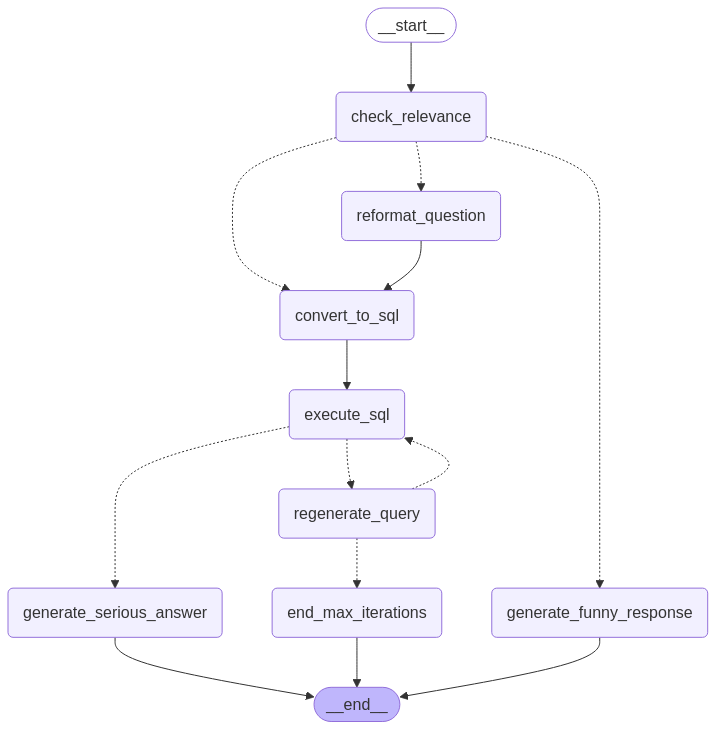

In [8]:
from IPython.display import Image

Image(
    chain.get_graph().draw_mermaid_png()
)


In [5]:
def main():
    print("Hi hi! I'm sOFIa, your assistant!")
    print("Let's get started by asking a question!")
    chat_history = []  # Store chat history outside the loop
    input_question = input()
    while input_question:
        # Check for exit or goodbye phrases
        if input_question.lower() in ["no", "exit", "goodbye", "quit"]:
            print("Goodbye! Have a great day!")
            break
        # Invoke the chain and ensure chat history persists
        state = chain.invoke({"original_question": input_question, "db_conn": db_conn, "chat_history": chat_history})
        # Get response and ensure sOFIa is not repeated
        response = state["final_answer"].replace("sOFIa: ", "").strip()
        # Print the response correctly
        print(f"sOFIa: {response}")
        relevance= state["relevance"]
        # Append the interaction to chat history
        chat_history.append(f"User: {input_question} [Relevance: {relevance}]")
        chat_history.append(f"sOFIa: {response}")
        # Get the next question
        input_question = input()
    # Print the chat history in a well-formatted way
    print("\nChat History:")
    for entry in chat_history:
        print(entry)

main()

Hi hi! I'm sOFIa, your assistant!
Let's get started by asking a question!
Checking relevance of the question: Hi!
Chat history for relevance check:

Relevance determined: not_relevant
Generating a funny response for an unrelated question.
sOFIa: Hello there, Stranger! Welcome to the world of sOFIa, your new best friend in this vast digital ocean. I'm here to make your day brighter, your laughter louder, and your life easier. So, what brings you to my corner of the internet today? Let's chat, have a laugh, or perhaps I can help you find that lost sock in the dryer of life! 😉
Checking relevance of the question: How long does it take, on average, for cases of type Renewal to be completed, and what are the most common activities causing delays?
Chat history for relevance check:

Relevance determined: relevant
Processed Question(s): ['What is the average time taken for completion of Renewal cases?', 'Which activities in the Renewal process cause the most delays?']
Converting question to SQL

In [35]:
a.consultar_db("""SELECT AVG(avg_time) FROM cases WHERE type = 'Renewal';
""")

,avg(avg_time)
0,909131.162998
